#   Naive Bayes Classifier with two approaches

In [ ]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mathx



iris = load_iris()

x = iris.data
y = iris.target


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

##  Classifier

In [331]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        self.priors = dict(Counter(train_classes))
        self.priors = {k: v / len(train_classes) for k, v in self.priors.items()}
        self.likelihoods = {k: {} for k in set(train_classes)}
        for k in self.likelihoods.keys():
            for i in range(train_features.shape[1]):
                self.likelihoods[k][i] = {}
                for j in set(train_features[:, i]):
                    self.likelihoods[k][i][j] = (train_features[train_classes == k, i] == j).sum() / len(
                        train_features[train_classes == k, i])
        

    @staticmethod
    def data_discretization(data, bins, mn=None, mx=None):
        data_copy = data.copy()
        for i in range(data_copy.shape[1]):
            # Determine the min and max values for the current feature
            min_val = np.min(data[:, i]) if mn is None else mn
            max_val = np.max(data[:, i]) if mx is None else mx
            # Create bin edges for the current feature
            bin_edges = np.linspace(min_val, max_val, bins + 1)
            # Digitize the data: assign each value to a bin
            data_copy[:, i] = np.digitize(data_copy[:, i], bins=bin_edges, right=False) - 1
        return data_copy



    def predict(self, sample):
        posteriors = {}
        for k in self.priors.keys():
            likelihood = 1
            for i in range(len(sample)):
                likelihood *= self.likelihoods[k][i].get(sample[i], 1e-6)  # Use a small value if key is not found
            posteriors[k] = likelihood * self.priors[k]
        return max(posteriors, key=posteriors.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        self.priors = dict(Counter(train_classes))
        self.priors = {k: v / len(train_classes) for k, v in self.priors.items()}
        self.likelihoods = {k: {} for k in set(train_classes)}
        for k in self.likelihoods.keys():
            for i in range(train_features.shape[1]):
                self.likelihoods[k][i] = (np.mean(train_features[train_classes == k, i]), np.std(train_features[train_classes == k, i]))

    @staticmethod
    def normal_dist(x, mean, std, epsilon=1e-6):
        std = max(std, epsilon)  # Avoid division by zero
        prob = 1 / (std * math.sqrt(2 * math.pi)) * math.exp(-0.5 * ((x - mean) / std) ** 2)
        return max(prob, epsilon)  # Ensure probability is never less than epsilon


    def predict(self, sample, log=False):
        posteriors = {}
        for k in self.priors.keys():
            if log:
                likelihood = math.log(self.priors[k])  # Start with the log of the prior
                for i in range(len(sample)):
                    likelihood += math.log(self.normal_dist(sample[i], self.likelihoods[k][i][0], self.likelihoods[k][i][1]))
            else:
                likelihood = self.priors[k]  # Start with the prior
                for i in range(len(sample)):
                    likelihood *= self.normal_dist(sample[i], self.likelihoods[k][i][0], self.likelihoods[k][i][1])
            posteriors[k] = likelihood
        return max(posteriors, key=posteriors.get)


##  Helper functions

0.9333333333333333


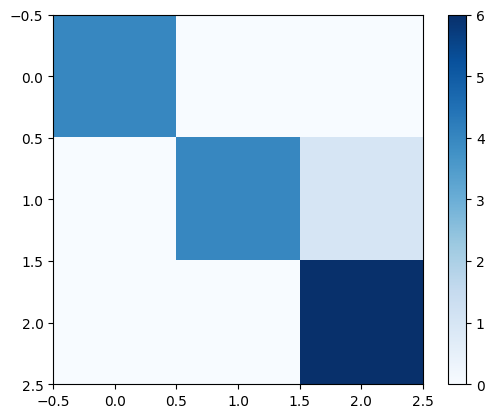

In [332]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

def confusion_matrix_display(y_true, y_pred, dimen):
    cm_display = np.zeros((dimen, dimen))
    for i in range(dimen):
        for j in range(dimen):
            cm_display[i, j] = np.sum((y_true == i) & (y_pred == j))
    return cm_display

def imshow_cm(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()

nb = NaiveBayes()
nb.build_classifier(nb.data_discretization(x_train, 4), y_train)
y_pred = np.array([nb.predict(i) for i in nb.data_discretization(x_test, 4)])
print(accuracy(y_test, y_pred))

imshow_cm(confusion_matrix_display(y_test, y_pred, 3))

1.0


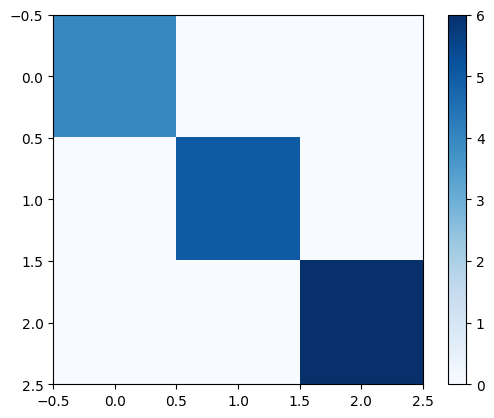

In [333]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
gnb = GaussianNaiveBayes()

gnb.build_classifier(x_train, y_train)
y_pred = np.array([gnb.predict(i) for i in x_test])
print(accuracy(y_test, y_pred))

imshow_cm(confusion_matrix_display(y_test, y_pred, 3))

#   Benchmarks for iris

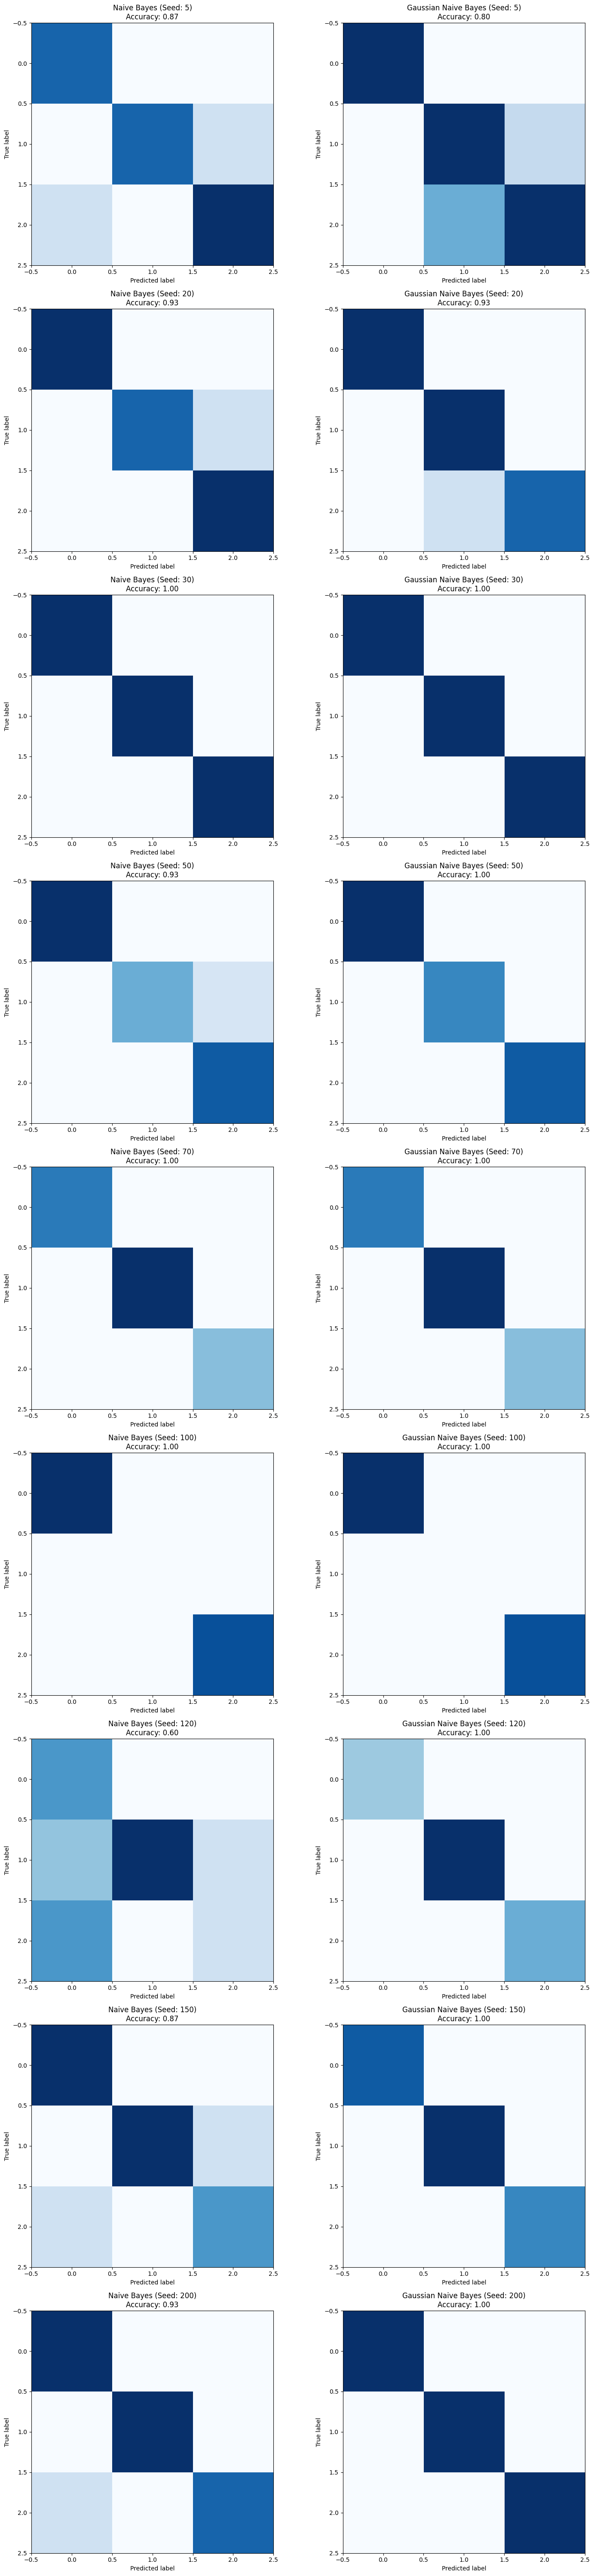

In [334]:
fig, ax = plt.subplots(9, 2, figsize=(15, 60))  # Adjusted the figure size for readability
dimen = np.unique(y).shape[0]  # Number of unique labels (classes)

for i, seed in enumerate([5, 20, 30, 50, 70, 100, 120, 150, 200]):
    nb = NaiveBayes()
    gnb = GaussianNaiveBayes()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed)
    
    # Naive Bayes
    nb.build_classifier(nb.data_discretization(x_train, 4), y_train)
    y_pred = np.array([nb.predict(i) for i in nb.data_discretization(x_test, 4)])
    acc = accuracy(y_test, y_pred)
    cm = confusion_matrix_display(y_test, y_pred, dimen)
    ax[i, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax[i, 0].set_title(f'Naive Bayes (Seed: {seed})\nAccuracy: {acc:.2f}')
    ax[i, 0].set_xlabel('Predicted label')
    ax[i, 0].set_ylabel('True label')
    
    # Gaussian Naive Bayes
    gnb.build_classifier(x_train, y_train)
    y_pred = np.array([gnb.predict(i) for i in x_test])
    acc = accuracy(y_test, y_pred)
    cm = confusion_matrix_display(y_test, y_pred, dimen)
    ax[i, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax[i, 1].set_title(f'Gaussian Naive Bayes (Seed: {seed})\nAccuracy: {acc:.2f}')
    ax[i, 1].set_xlabel('Predicted label')
    ax[i, 1].set_ylabel('True label')

plt.tight_layout()  # To adjust spacing between subplots
plt.show()

#   Benchmarks for mnist

In [335]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

In [336]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
x = mnist.data.to_numpy()  # 70000 samples of 28x28 pixels (flattened)
y = mnist.target.astype(int).to_numpy()  # Labels (0 to 9)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
x_train_discretized = NaiveBayes.data_discretization(x_train, bins=10, mn=0, mx=255)
x_test_discretized = NaiveBayes.data_discretization(x_test, bins=10, mn=0, mx=255)

Accuracy for Discrete Naive Bayes: 0.8254285714285714
Confusion Matrix for Discrete Naive Bayes:


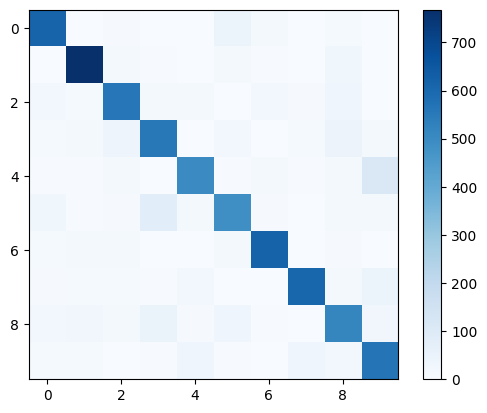

In [337]:
# Initialize and train Discrete Naive Bayes
nb = NaiveBayes()
nb.build_classifier(x_train_discretized, y_train)

# Predictions for Discrete Naive Bayes
y_pred_nb = np.array([nb.predict(sample) for sample in x_test_discretized])

# Calculate and print accuracy
print(f"Accuracy for Discrete Naive Bayes: {accuracy(y_test, y_pred_nb)}")

# Display confusion matrices
cm_nb = confusion_matrix_display(y_test, y_pred_nb, dimen=10)

print("Confusion Matrix for Discrete Naive Bayes:")
imshow_cm(cm_nb)

In [338]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
X_train = X_train / 255

Accuracy for Gaussian Naive Bayes: 0.12414285714285714
Confusion Matrix for Gaussian Naive Bayes:


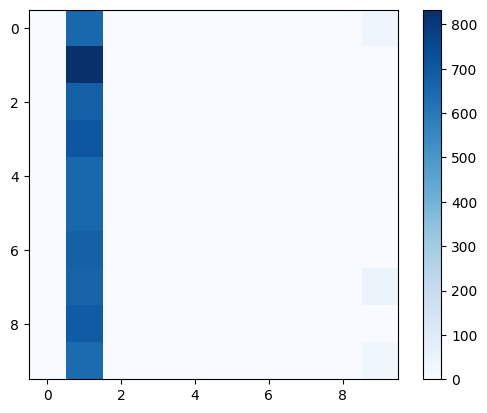

In [339]:
# Initialize and train Gaussian Naive Bayes
gnb = GaussianNaiveBayes()
gnb.build_classifier(X_train, y_train)

# Predictions for Gaussian Naive Bayes
y_pred = np.array([gnb.predict(sample, log=True) for sample in X_test])

# Calculate and print accuracy
print(f"Accuracy for Gaussian Naive Bayes: {accuracy(y_test, y_pred)}")

# Display confusion matrices
cm_gnb = confusion_matrix_display(y_test, y_pred, dimen=10)

print("Confusion Matrix for Gaussian Naive Bayes:")
imshow_cm(cm_gnb)

#   Conclusions

-   The method with normal distribution seems to be more efficient, at least when we divide the attributes into 4 intervals during discretization.
-   The classifier works really well for simple datasets (iris is definitely one of them), which are characterized by high attribute independence.
-   In the case of more complex datasets like mnist, the discretization version works surprisingly well (still much worse than a convolutional network), while in the case of the method with normal distribution, strange things happen, which may be caused by the huge number of parameters.